In [84]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import pandas, numpy, matplotlib, matplotlib.pyplot as plt, seaborn, datetime, matplotlib.cm as cm
import math, matplotlib.colors as colors
from matplotlib import gridspec
from enum import Enum
from scipy import interpolate
from sklearn.neighbors import LocalOutlierFactor
from IPython.display import display, HTML, Markdown
import seaborn as sns
sns.set(style="whitegrid")


class Interpolation(Enum):
    LINEAR = 1
    CUBIC = 2
    SPLINE = 3
    RBF = 4



In [85]:
# Parâmetros para dados
DATA_PATH = [
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part1]\8123_080802018_8123_[part1]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part2]\8123_080802018_8123_[part2]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part3]\8123_080802018_8123_[part3]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part4]\8123_080802018_8123_[part4]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part5]\8123_080802018_8123_[part5]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part6]\8123_080802018_8123_[part6]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part7]\8123_080802018_8123_[part7]_sampled_preprocessedMinMax.csv',
             'C:\Mestrado\Dados\TEMP_AGUA\Original\8123_08082018\8123_080802018_8123_[part8]\8123_080802018_8123_[part8]_sampled_preprocessedMinMax.csv'
             ]

relevantAttributes = ['PLUB',"MT1","POT","PCOMB","PTO","VGA","VGP","TH2O",'TOD','TOA',"GPSVEL","IGA","IGP"]

FAULT_DATE          = "2018-08-08"
SAMPLING_FREQUENCY  = "90T" # 90 minutos
TIME_BEFORE_FAULT   = "7D"
TIME_AFTER_FAULT    = "1D"
TIME_SERIES_COLUMN  = 'DateTime'



In [86]:
# Parâmetros para os gráficos
COLORMAP_BEFORE_FAULT = "Greens"
LINE_ALPHA = 0.7
XTICKS_DENSITY = .10
PCP_COLORBAR_RATE = [10,1]
COLORBAR_INTERPOLATION = 'None'
INTERPOLATION_SAMPLES = 100

# Estilo gráficos 
#matplotlib.style.use('classic')
matplotlib.rcParams['figure.figsize'] = [11, 4]

# Análise temporal 
LOF_N_NEIGHBORS   = 20
LOF_CONTAMINATION = .1



In [87]:
# Processa os dias de interesse
faultDate = pandas.to_datetime(FAULT_DATE)
startDate = faultDate - pandas.to_timedelta(TIME_BEFORE_FAULT)
endDate   = faultDate + pandas.to_timedelta(TIME_AFTER_FAULT)

print(startDate,faultDate,endDate)



2018-08-01 00:00:00 2018-08-08 00:00:00 2018-08-09 00:00:00


In [88]:
# Organização dados
def prepareLoadDataframe(filename):
    df = pandas.read_csv(filename)

    df['time'] = pandas.to_datetime(df[TIME_SERIES_COLUMN])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    df = df[relevantAttributes]

    return df[startDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S"):endDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")].resample(SAMPLING_FREQUENCY).max()




dataframeList = [prepareLoadDataframe(x) for x in DATA_PATH]
resampledDf = pandas.concat(dataframeList).dropna()
resampledDf.sort_index(inplace=True)



In [89]:
def pythonDatetimeToString(datetimeValue):
    return datetimeValue.strftime("%Y-%m-%d %H:%M:%S")
def pandasDatetimeToString(datetimeValue):
    return datetimeValue.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")



In [90]:
y  = resampledDf.values
x = [a for a in range(0,len(resampledDf.columns))]



In [91]:
def createColormapSequence(colormap, baseList, outliersCount):
    norm = colors.Normalize(vmin=min(baseList), vmax=max(baseList))
    lineColor = [colormap(norm(x)) for x in baseList]

    outlierColormap = plt.get_cmap("Reds")
    outlierNorm = colors.Normalize(vmin=0, vmax=outliersCount)
    outlierColor = [outlierColormap(outlierNorm(outliersCount-x)) for x in range(0, outliersCount)]

    #lineColor+= [(1,0,0,.1)]*outliersCount
    return lineColor+outlierColor

#quantas cores sao necessarias
instancesBeforeFault = len(resampledDf[:faultDate])-1 # -1 porque considera eh <=
instancesAfterFault  = len(resampledDf[faultDate:])

#colormap para antes da falha
colormapBeforeFault = plt.get_cmap(COLORMAP_BEFORE_FAULT)

# valores base para as cores
logScale = [math.log10(x) for x in range(1,instancesBeforeFault+1)]
linearScale = [x/(instancesBeforeFault+1) for x in range(1,instancesBeforeFault+1)]
logRevScale = [1-math.log10(x) for x in range(instancesBeforeFault+1,1,-1)]


#
logColormap    = createColormapSequence(colormapBeforeFault,logScale,   instancesAfterFault)
linearColormap = createColormapSequence(colormapBeforeFault,linearScale,instancesAfterFault)
logRevColormap = createColormapSequence(colormapBeforeFault,logRevScale,instancesAfterFault)



In [92]:
# HORIZONTAL COLORBAR - SE VOLTAR A PRECISAR
#fig, ax = plt.subplots(figsize=(18, 2))
#rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in logColormap]


#dateTicksBefore = numpy.linspace(0, instancesBeforeFault, num=int(instancesBeforeFault*XTICKS_DENSITY))
#dateTicksAfter = numpy.linspace(instancesBeforeFault, instancesBeforeFault+instancesAfterFault-1, num=int(instancesAfterFault*XTICKS_DENSITY))

#dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
#dateTicks.astype(int)


#img = numpy.array(rgb_array, dtype=int).reshape((1, len(rgb_array), 3))
#ax.imshow(img, aspect='auto', interpolation='nearest')
#ax.grid(False)

#ax.set_yticks([])
#ax.set_xticks(dateTicks)
#ax.set_xticklabels(resampledDf.iloc[teste].index)
#ax.set_xticklabels(resampledDf.iloc[dateTicks].index, rotation=+90, ha="center")

#plt.show()



In [108]:
def plotPcp(dataframe,lineColor, ax=None, interpolation=None):
    
    if ax is None:
        # cria a figura 
        fig = plt.figure()
        ax = plt.gca()

    x = [a for a in range(0,len(dataframe.columns))]

    # Eixos verticais
    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    # Nome/posição dos atributos nos eixos
    ax.set_xticks(x)
    ax.set_xticklabels(relevantAttributes)

    # Remove marcações no eixo Y
    ax.set_yticks([])
    
    # Remove margens
    ax.set_xlim(x[0], x[-1])

    maxYValue = .5
    minYValue = .5

    if interpolation is None:
        ax.set_ylim(-0.05, 1.05)

        for i in range(len(y)):

            interpolatedY = dataframe.iloc[i]
            ax.plot(x,interpolatedY,color=lineColor[i])

            if(maxYValue < max(interpolatedY)): 
                maxYValue = max(interpolatedY)
            if(minYValue > min(interpolatedY)): 
                minYValue = min(interpolatedY)
    else:
        
        xi = numpy.linspace(0,len(dataframe.columns)-1,INTERPOLATION_SAMPLES)

        for i in range(len(y)):

            if interpolation == Interpolation.LINEAR:
                interpolationMethod = interpolate.interp1d(x, dataframe.iloc[i].values)
            elif interpolation == Interpolation.CUBIC:        
                interpolationMethod = interpolate.interp1d(x, dataframe.iloc[i].values, kind='cubic')
            elif interpolation == Interpolation.SPLINE: 
                interpolationMethod = interpolate.InterpolatedUnivariateSpline(x, dataframe.iloc[i].values)
            elif interpolation == Interpolation.RBF: 
                interpolationMethod = interpolate.Rbf(x, dataframe.iloc[i].values)
            else:
                return
            
            interpolatedY = interpolationMethod(xi)
            ax.plot(xi,interpolatedY,color=lineColor[i])

            if(maxYValue < max(interpolatedY)): 
                maxYValue = max(interpolatedY)
            if(minYValue > min(interpolatedY)): 
                minYValue = min(interpolatedY)

    # Acerta o eixo Y com base nos valores do gráfico
    correctionYMin = -.05 if minYValue == 0 else minYValue-(minYValue*.05)
    correctionYMax =  .05 if maxYValue == 0 else maxYValue+(maxYValue*.05)          
    ax.set_ylim(correctionYMin, correctionYMax)



In [94]:
def plotVerticalColorbar(labels, lineColor, elementsBeforeFault, elementsAfterFault, ticksDensity, ax):

    # Converte de percentual de RGB para RGB
    rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in lineColor]

    # Alinhamento na vertical  
    verticalAlignedData = numpy.array(rgb_array, dtype=int).reshape((len(rgb_array), 1, 3))[::-1]

    # Plota
    ax.imshow(verticalAlignedData, extent=[0, 1, 0, len(rgb_array)], aspect='auto', interpolation=COLORBAR_INTERPOLATION)
    
    # remove grid 
    ax.grid(False)

    # Sem labels na horizontal
    ax.set_xticks([])

    # Labels na vertical

    dateTicksBefore = numpy.linspace(0, elementsBeforeFault, num=int(elementsBeforeFault*ticksDensity))
    dateTicksAfter = numpy.linspace(elementsBeforeFault, elementsBeforeFault+elementsAfterFault-1, num=math.ceil(elementsAfterFault*ticksDensity))

    dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
    dateTicks = dateTicks.astype(int)

    ax.set_yticks(dateTicks)
    ax.set_yticklabels(numpy.take(labels,dateTicks), rotation=0, ha="left",va = 'center', minor=False)

    # Labels do lado direito da figura    
    ax.yaxis.tick_right()



In [95]:
def completePicture(dataframe, cmap, elementsBeforeFault, elementsAfterFault, title, interpolation=None):

    fig = plt.figure()
    
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                            width_ratios=PCP_COLORBAR_RATE)
    
    ax0 = fig.add_subplot(spec[0])
    ax0.title.set_text(title)
    plotPcp(dataframe,cmap,ax0,interpolation)

    ax1 = fig.add_subplot(spec[1])
    plotVerticalColorbar(dataframe.index.strftime("%m/%d/%Y %H:%M:%S"),cmap, elementsBeforeFault, elementsAfterFault, XTICKS_DENSITY, ax1)

    plt.show()



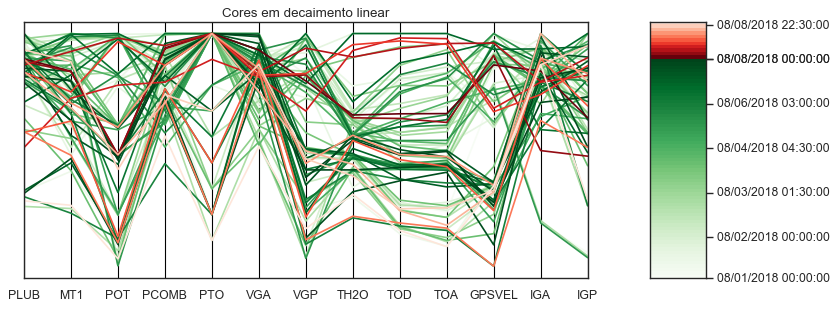

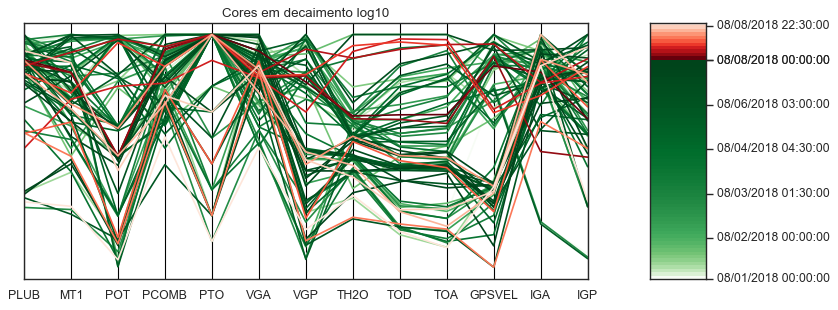

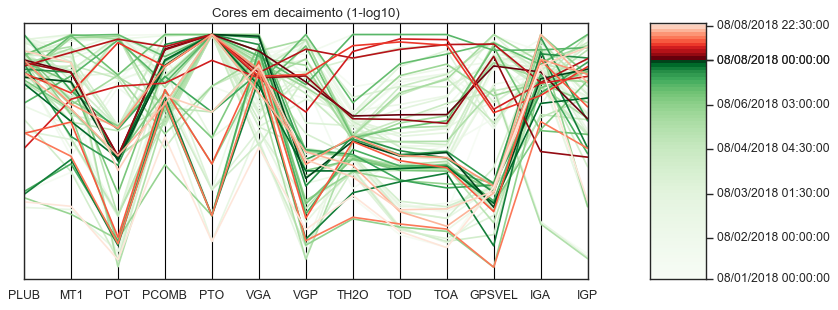

In [109]:
completePicture(resampledDf,linearColormap,instancesBeforeFault, instancesAfterFault, "Cores em decaimento linear")
completePicture(resampledDf,logColormap,instancesBeforeFault, instancesAfterFault, "Cores em decaimento log10")
completePicture(resampledDf,logRevColormap,instancesBeforeFault, instancesAfterFault, "Cores em decaimento (1-log10)")



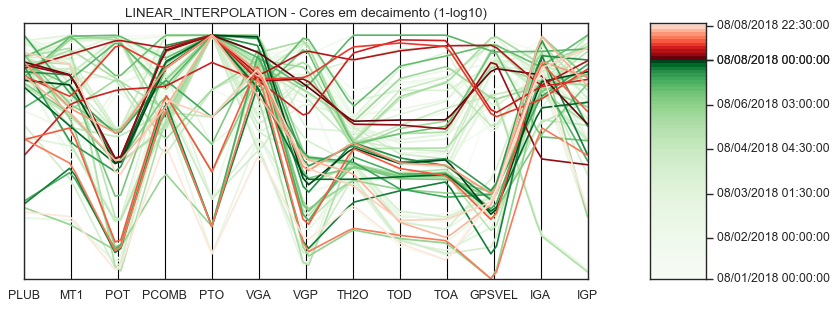

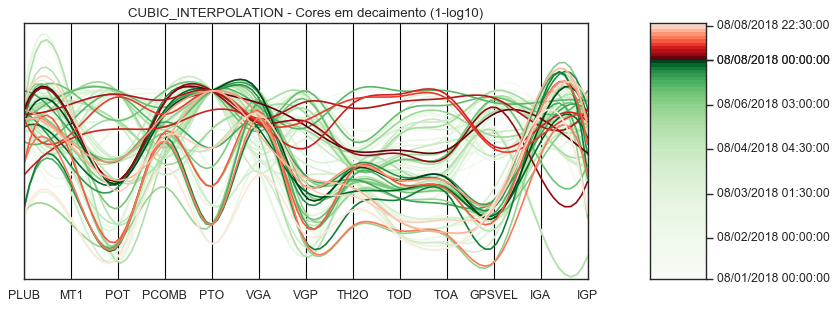

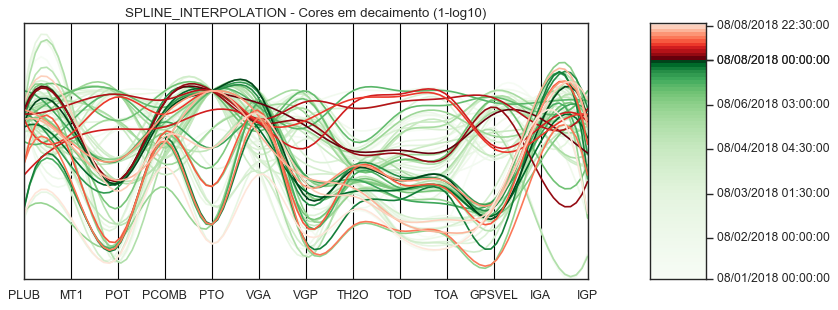

In [110]:
completePicture(resampledDf,logRevColormap,instancesBeforeFault, instancesAfterFault, "LINEAR_INTERPOLATION - Cores em decaimento (1-log10)", Interpolation.LINEAR)  
completePicture(resampledDf,logRevColormap,instancesBeforeFault, instancesAfterFault, "CUBIC_INTERPOLATION - Cores em decaimento (1-log10)",  Interpolation.CUBIC)  
completePicture(resampledDf,logRevColormap,instancesBeforeFault, instancesAfterFault, "SPLINE_INTERPOLATION - Cores em decaimento (1-log10)", Interpolation.SPLINE)  
#completePicture(resampledDf,logRevColormap,instancesBeforeFault, instancesAfterFault, "Rbf_INTERPOLATION- Cores em decaimento (1-log10)",     Interpolation.RBF)  



In [130]:
def timeSeriePlot(dataframe, linecolor):

    dataframe =  dataframe.copy()

    # duas imagens, sem espaco entre elas
    fig, axs = plt.subplots(2, sharex=False, sharey=False, gridspec_kw={'hspace': 0},figsize=(15,7))
    ax1 = axs[0]
    ax2 = axs[1]

    # primeiro grafico de linhas
    dataframe.plot.line(ax=ax1)
    ax1.set_xticklabels([])
    ax1.legend(bbox_to_anchor=(1.05, 1.0),loc='upper')

    # insere linha em X com a data de quando comecou a falha
    ax1.axvline(faultDate, linestyle='--', lw=3, color='red')

    yticks = numpy.linspace(0, 1, num=5)[1:]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([ "{:0.0f}".format(x*100) for x in yticks])

    ax1.set_ylabel('Valor percentual (%)')

    ax1.set_ylim(0,1.1)


    # Calculo do fator de
    lof = LocalOutlierFactor(n_neighbors=20, contamination=.1)
    lof.fit_predict(dataframe)
    lof.negative_outlier_factor_
    dataframe["LOF_normalized"] = lof.negative_outlier_factor_/lof.negative_outlier_factor_.min()*(-1)
    dataframe["linecolor"] = linecolor

    dailySampled= dataframe.resample("12h")
    barYError   = dailySampled["LOF_normalized"].std().values
    barPlotData = dailySampled["LOF_normalized"].mean()
    barXPosition= numpy.linspace(.5,len(barPlotData.index.values)-.5,len(barPlotData.index.values))
    barColor    = dailySampled["linecolor"].last()

    ax2.set_ylabel('LOF')

    for i in range(len(barPlotData.values)): 
        if not numpy.isnan(barPlotData.values[i]):        
          ax2.bar(barXPosition[i],
                  barPlotData.values[i],
                  yerr=barYError[i],
                  color=barColor[i],
                  width=1)

    ax2.tick_params(axis='y')
    ax2.set_ylim(-1.2,0)

    ax2.set_xticklabels(barPlotData.index.strftime("%m/%d/%Y"), rotation=45, ha='center')
    ax2.grid(False)

    fig.tight_layout()
    plt.show()




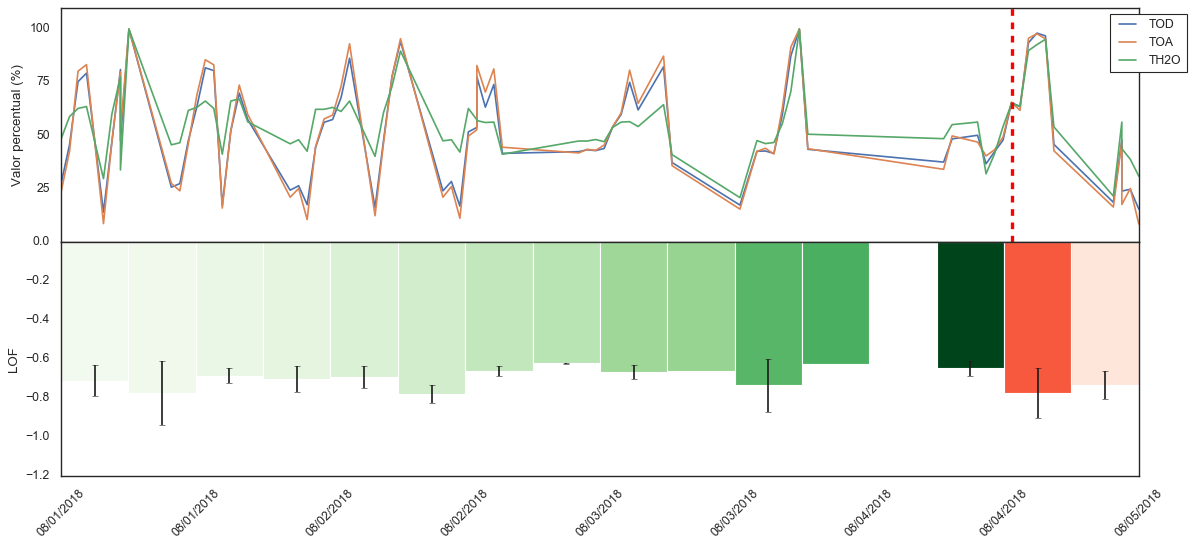

In [131]:
bestRatedSubspace = ["TOD", "TOA", "TH2O"]
timeSeriePlot(resampledDf[bestRatedSubspace], logRevColormap)



In [118]:
numpy.linspace(0, 1, num=5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])